In [34]:
# !pip install swifter
# !pip install tensorflow

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [36]:
DATASET_PATH = "./fashion-dataset/"
print(os.listdir(DATASET_PATH))

['images', 'images.csv', 'styles', 'styles.csv']


In [37]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [38]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

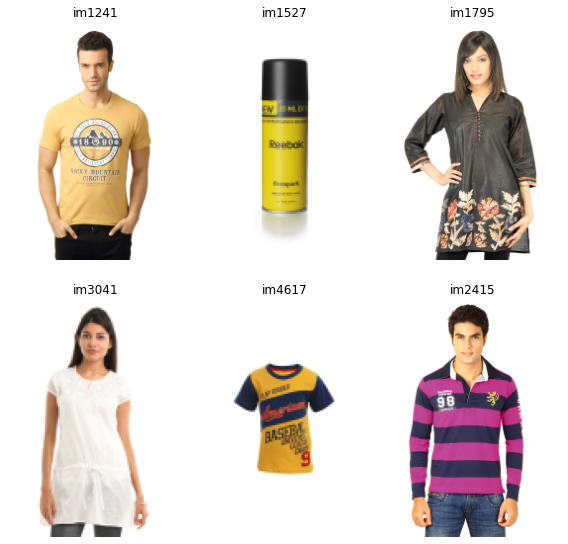

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [52]:
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.9.1'

In [48]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94765736/94765736 [==============================] - 12s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [49]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [53]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

1/1 [==============================] - 2s 2s/step


(2048,)

(240, 180, 3)
[ 5.661312   2.3661578  0.        ...  1.3138627  0.        10.820534 ]


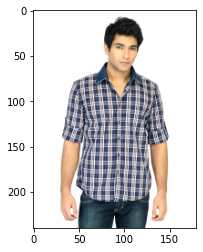

In [54]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [55]:
df.shape

(5000, 11)

In [56]:
%%time
#import swifter

# Parallel apply
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 227ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 199ms/step
(5000, 2048)
Wall time: 19min 15s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.661312,2.366158,0.000000,3.255738,0.845206,2.673840,8.780885,6.280785,0.787186,1.587662,...,2.463607,0.000000,1.825990,20.485271,3.902871,0.000000,8.225971,1.313863,0.000000,10.820534
1,5.790412,9.593652,0.000000,9.431687,0.287238,0.259950,17.028755,3.037456,0.136339,0.000000,...,1.670569,0.013894,10.338678,4.784732,0.189142,0.000000,7.739138,0.372693,0.000000,8.903797
2,0.000000,3.162264,0.484694,0.172313,2.609545,3.840852,3.426132,0.253247,1.098901,1.418278,...,0.434923,14.092848,3.018758,2.134510,2.549057,0.377387,6.180353,0.636621,14.018168,11.415053
3,5.882204,1.958622,0.000000,12.519884,0.000000,0.000000,9.383584,3.781623,0.000000,1.490620,...,17.825481,0.000000,3.592511,2.042306,0.000000,0.000000,6.656784,1.457313,1.694215,1.403331
4,0.245960,17.383436,0.493822,3.374463,2.567366,0.000000,6.482548,5.862635,0.000000,3.164864,...,4.464021,0.447082,1.448132,12.884141,0.000000,0.397488,5.028076,1.939697,0.000000,11.485396


In [57]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.7134497 , 0.4542722 , 0.67970586],
       [0.7134497 , 0.99999976, 0.41515315, 0.8333089 ],
       [0.4542722 , 0.41515315, 0.9999989 , 0.44629467],
       [0.67970586, 0.8333089 , 0.44629467, 0.99999917]], dtype=float32)

Recommender Similar Items

In [58]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Int64Index([251, 659, 2400, 0, 1821], dtype='int64'),
 [0.9236278, 0.92232645, 0.91904217, 0.915087, 0.91311723])

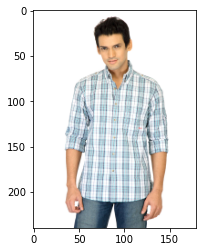

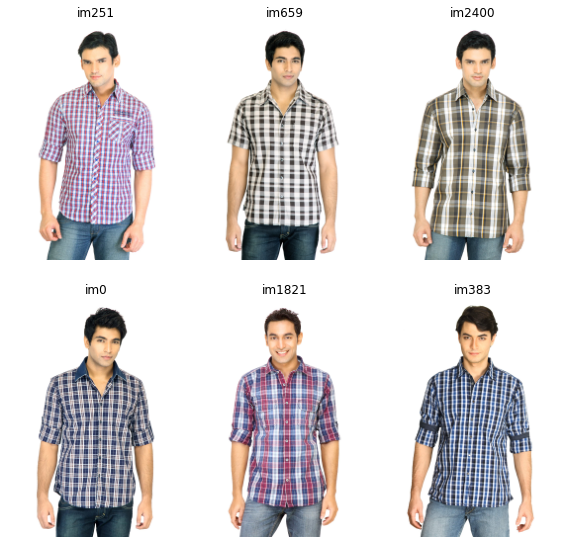

In [59]:
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

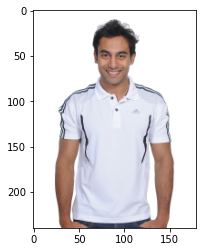

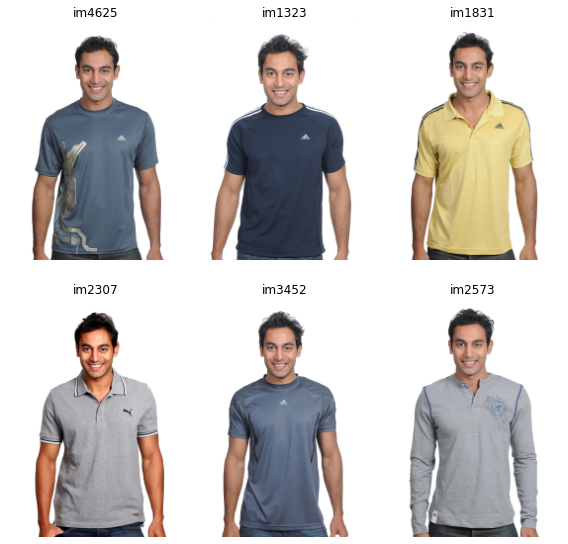

In [61]:
idx_ref = 888

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

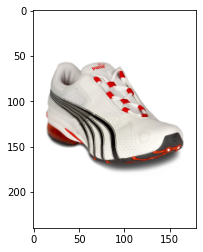

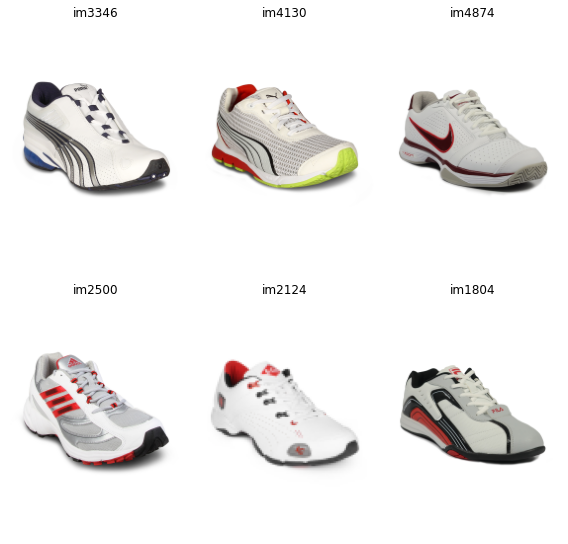

In [62]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

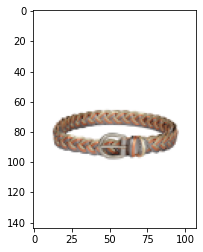

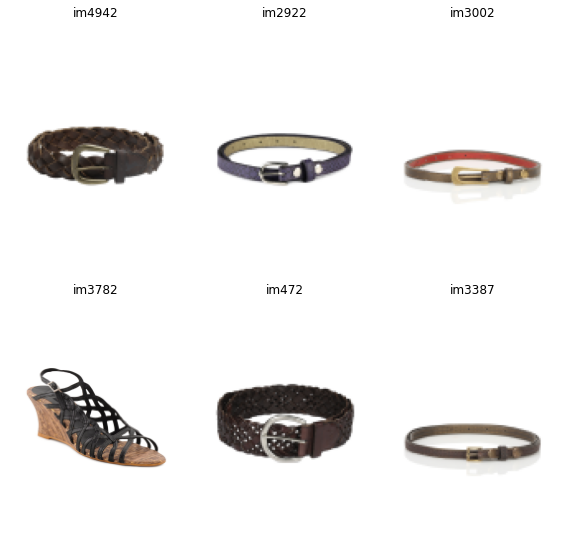

In [63]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# Visualization Latent Space of Contents

In [64]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [65]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [72]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate='auto', init='random')
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 10.459411859512329 seconds


In [73]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

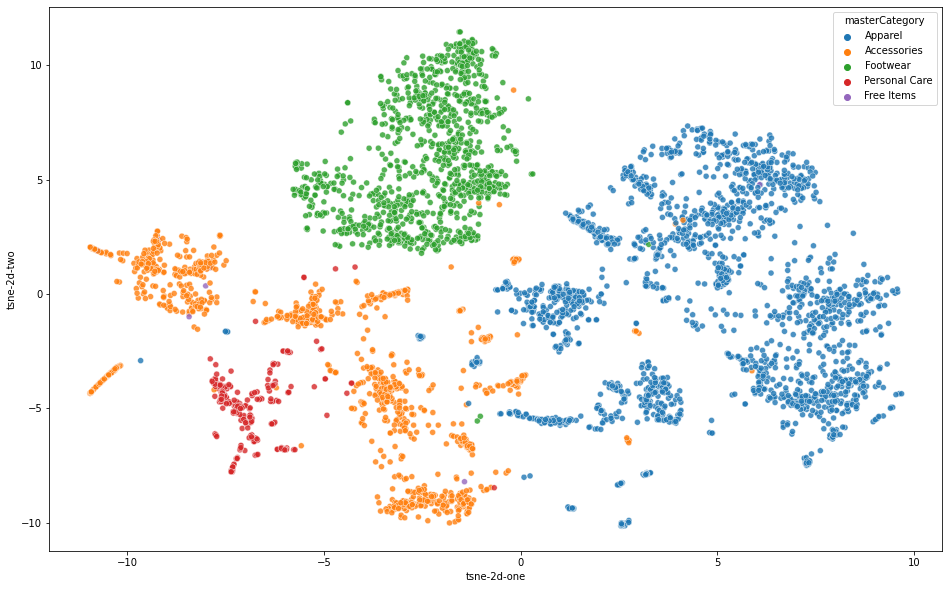

In [74]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

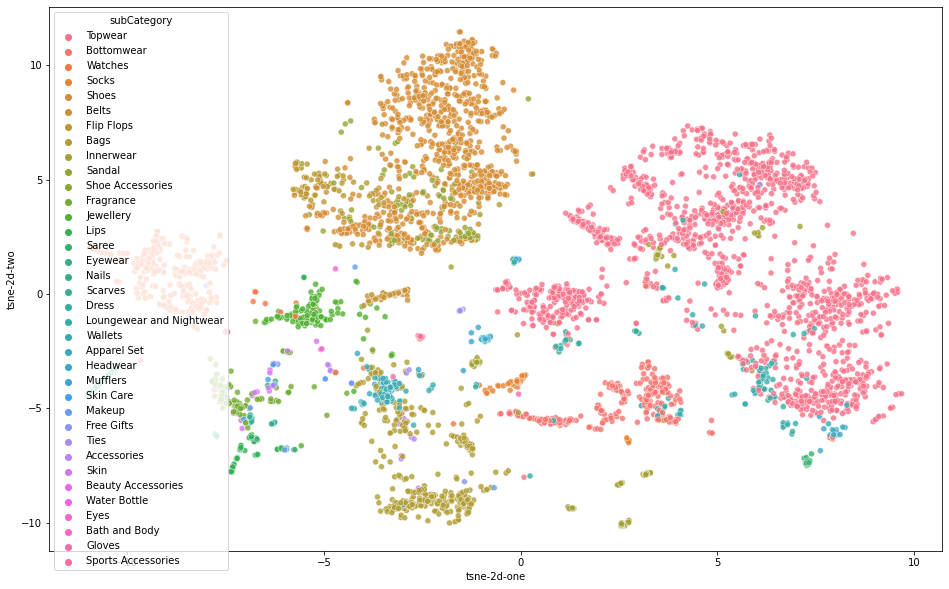

In [75]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [76]:
df.sample(10).to_csv('df_sample.csv')
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')

In [78]:
pd.read_csv('df_sample.csv')

,Unnamed: 0,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,tsne-2d-one,tsne-2d-two
0,4948,12100,Women,Apparel,Topwear,Kurtas,Multi,Fall,2011,Ethnic,W Women Multi Colour Printed Kurta,12100.jpg,7.694240,-4.264720
1,1635,45834,Women,Apparel,Topwear,Kurtas,Red,Summer,2012,Ethnic,Vishudh Women Red Kurta,45834.jpg,6.508535,-4.015764
2,3413,27075,Women,Footwear,Shoes,Heels,Black,Winter,2015,Casual,Catwalk Women Black Heels,27075.jpg,-1.390836,2.421794
3,3734,14437,Women,Footwear,Shoes,Heels,Silver,Summer,2012,Casual,Enroute Women Silver Wedges,14437.jpg,-1.696550,3.865126
4,1613,23814,Men,Footwear,Shoes,Casual Shoes,Black,Fall,2011,Casual,Puma Men Neo Low Black Casual Shoes,23814.jpg,-2.894481,4.141564
5,2287,23489,Men,Footwear,Shoes,Sports Shoes,Black,Fall,2011,Sports,FILA Men Forza 11 Black Sports Shoes,23489.jpg,-2.466288,7.512773
6,2714,32198,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012,Ethnic,Fabindia Men Printed Grey Kurta,32198.jpg,9.678122,-4.358161
7,606,32564,Women,Apparel,Bottomwear,Trousers,Orange,Summer,2012,Casual,ONLY Women Orange Trousers,32564.jpg,3.092379,-3.072420
8,3139,39184,Women,Apparel,Topwear,Kurtas,Multi,Summer,2012,Ethnic,Aneri Women Multi Coloured Kurta,39184.jpg,9.094627,-3.979245
9,1231,5898,Men,Footwear,Shoes,Casual Shoes,Blue,Summer,2011,Casual,Puma Men Tekkies Jam Blue Shoe,5898.jpg,-3.143326,8.697240


In [79]:
pd.read_csv('embeddings.csv')

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,5.661312,2.366158,0.000000,3.255738,0.845206,2.673840,8.780885,6.280785,0.787186,...,2.463607,0.000000,1.825990,20.485271,3.902871,0.000000,8.225971,1.313863,0.000000,10.820534
1,1,5.790412,9.593652,0.000000,9.431687,0.287238,0.259950,17.028755,3.037456,0.136339,...,1.670569,0.013894,10.338678,4.784732,0.189142,0.000000,7.739138,0.372693,0.000000,8.903797
2,2,0.000000,3.162264,0.484694,0.172313,2.609545,3.840852,3.426132,0.253248,1.098901,...,0.434923,14.092848,3.018758,2.134510,2.549056,0.377387,6.180353,0.636621,14.018168,11.415053
3,3,5.882204,1.958622,0.000000,12.519884,0.000000,0.000000,9.383584,3.781623,0.000000,...,17.825481,0.000000,3.592511,2.042306,0.000000,0.000000,6.656784,1.457313,1.694215,1.403331
4,4,0.245960,17.383436,0.493822,3.374463,2.567366,0.000000,6.482548,5.862635,0.000000,...,4.464021,0.447082,1.448132,12.884141,0.000000,0.397488,5.028076,1.939697,0.000000,11.485396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,0.000000,0.321079,2.286413,1.358242,0.462969,9.163935,2.768785,5.362484,0.000000,...,0.000000,9.330203,6.249788,4.409953,5.866289,6.166033,3.572124,3.106232,0.000000,2.379206
4996,4996,2.078959,6.525011,2.159777,1.577380,11.478320,1.587174,0.560384,0.000000,2.502835,...,0.000000,1.123391,0.093614,5.718954,3.173695,0.000000,12.184820,0.562904,6.811969,0.000000
4997,4997,3.184307,14.538850,6.306132,0.000000,3.361141,6.701037,0.729836,0.295348,0.252367,...,0.000000,1.471542,1.482234,22.654333,2.425650,12.427610,8.393598,0.000000,9.616657,3.375092
4998,4998,0.495716,0.754575,5.361824,2.251381,5.059067,4.944987,6.025792,8.423908,0.000000,...,0.536612,12.328587,4.785463,0.000000,4.667118,5.777933,3.781093,2.007558,8.635370,4.528846


In [80]:
pd.read_csv('metadados.csv')

,Unnamed: 0,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,tsne-2d-one,tsne-2d-two
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,5.172307,0.666566
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg,3.305236,-4.146963
2,2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg,-7.540337,1.265780
3,3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,3.293729,-4.683672
4,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg,5.071642,3.664021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,44573,Men,Footwear,Sandal,Sandals,Brown,Summer,2012,Casual,Coolers Men Brown Sandals,44573.jpg,-1.952557,4.184812
4996,4996,37081,Women,Accessories,Bags,Handbags,Brown,Summer,2012,Casual,Lino Perros Women Brown Handbag,37081.jpg,-2.575745,-8.576002
4997,4997,57958,Women,Apparel,Saree,Sarees,Green,Summer,2012,Ethnic,Prafful Green Printed Sari,57958.jpg,7.324186,-7.371225
4998,4998,5654,Men,Footwear,Shoes,Sports Shoes,White,Summer,2011,Sports,Reebok Men's Winning Stride White Shoe,5654.jpg,-2.118088,9.706778
